<a href="https://colab.research.google.com/github/hannesstuehrenberg/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/main/projects/08-1SHXXXX_football_analytics/notebooks/02_data_loading_and_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2. Data Loading and Exploration

- Code to load data
- Basic exploration (plots, statistics, missing data, etc.)

In [27]:
#mplsoccer is a Python library for plotting football charts in Matplotlib and loading StatsBomb open-data
!pip install mplsoccer
#Squarify is a Python library used to create treemap visualizations
!pip install squarify

In [28]:
#Import necessary libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import VerticalPitch
from mplsoccer import Sbopen
import squarify

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Initialize parser
parser = Sbopen()

In [29]:
#First I want to get an overview of the available matches in my data. Statsbomb provides the data via an API. Competition data can be accessed like this:

df_competition = parser.competition()
df_competition.info()
df_competition.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   competition_id             74 non-null     int64 
 1   season_id                  74 non-null     int64 
 2   country_name               74 non-null     object
 3   competition_name           74 non-null     object
 4   competition_gender         74 non-null     object
 5   competition_youth          74 non-null     bool  
 6   competition_international  74 non-null     bool  
 7   season_name                74 non-null     object
 8   match_updated              74 non-null     object
 9   match_updated_360          56 non-null     object
 10  match_available_360        10 non-null     object
 11  match_available            74 non-null     object
dtypes: bool(2), int64(2), object(8)
memory usage: 6.1+ KB


,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-06-13T07:51:02.452825,None,None,2024-06-13T07:51:02.452825
3,16,4,Europe,Champions League,male,False,False,2018/2019,2024-06-12T07:44:38.559714,2021-06-13T16:17:31.694,None,2024-06-12T07:44:38.559714
4,16,1,Europe,Champions League,male,False,False,2017/2018,2024-02-13T02:35:28.134882,2021-06-13T16:17:31.694,None,2024-02-13T02:35:28.134882


In [30]:
#This loads all matches across competitions and seasons available using the competition and the match interface of the API

all_matches = pd.DataFrame()
df_competition = parser.competition()

for _, row in df_competition.iterrows():
    try:
        matches = parser.match(row['competition_id'], row['season_id'])
        all_matches = pd.concat([all_matches, matches], ignore_index=True)
    except:
        continue

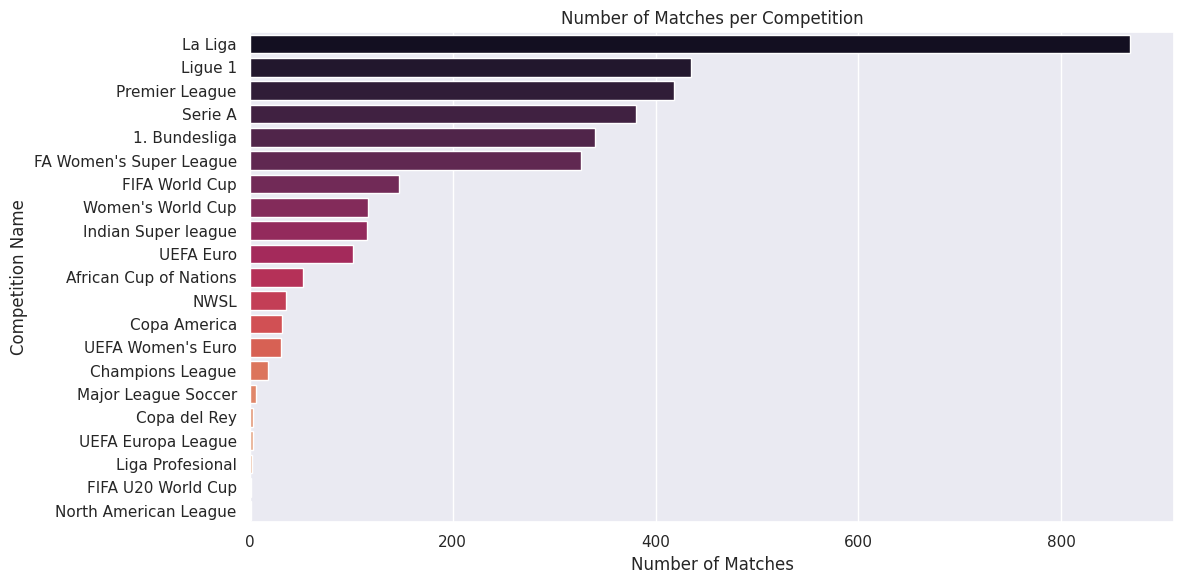

In [31]:
#First I want to understand how many matches are available per competition. Therefore, a simple bar chart is created.

match_counts = all_matches.groupby('competition_name').size().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=match_counts.values, y=match_counts.index, palette="rocket")

plt.title('Number of Matches per Competition')
plt.xlabel('Number of Matches')
plt.ylabel('Competition Name')
plt.tight_layout()
plt.show()

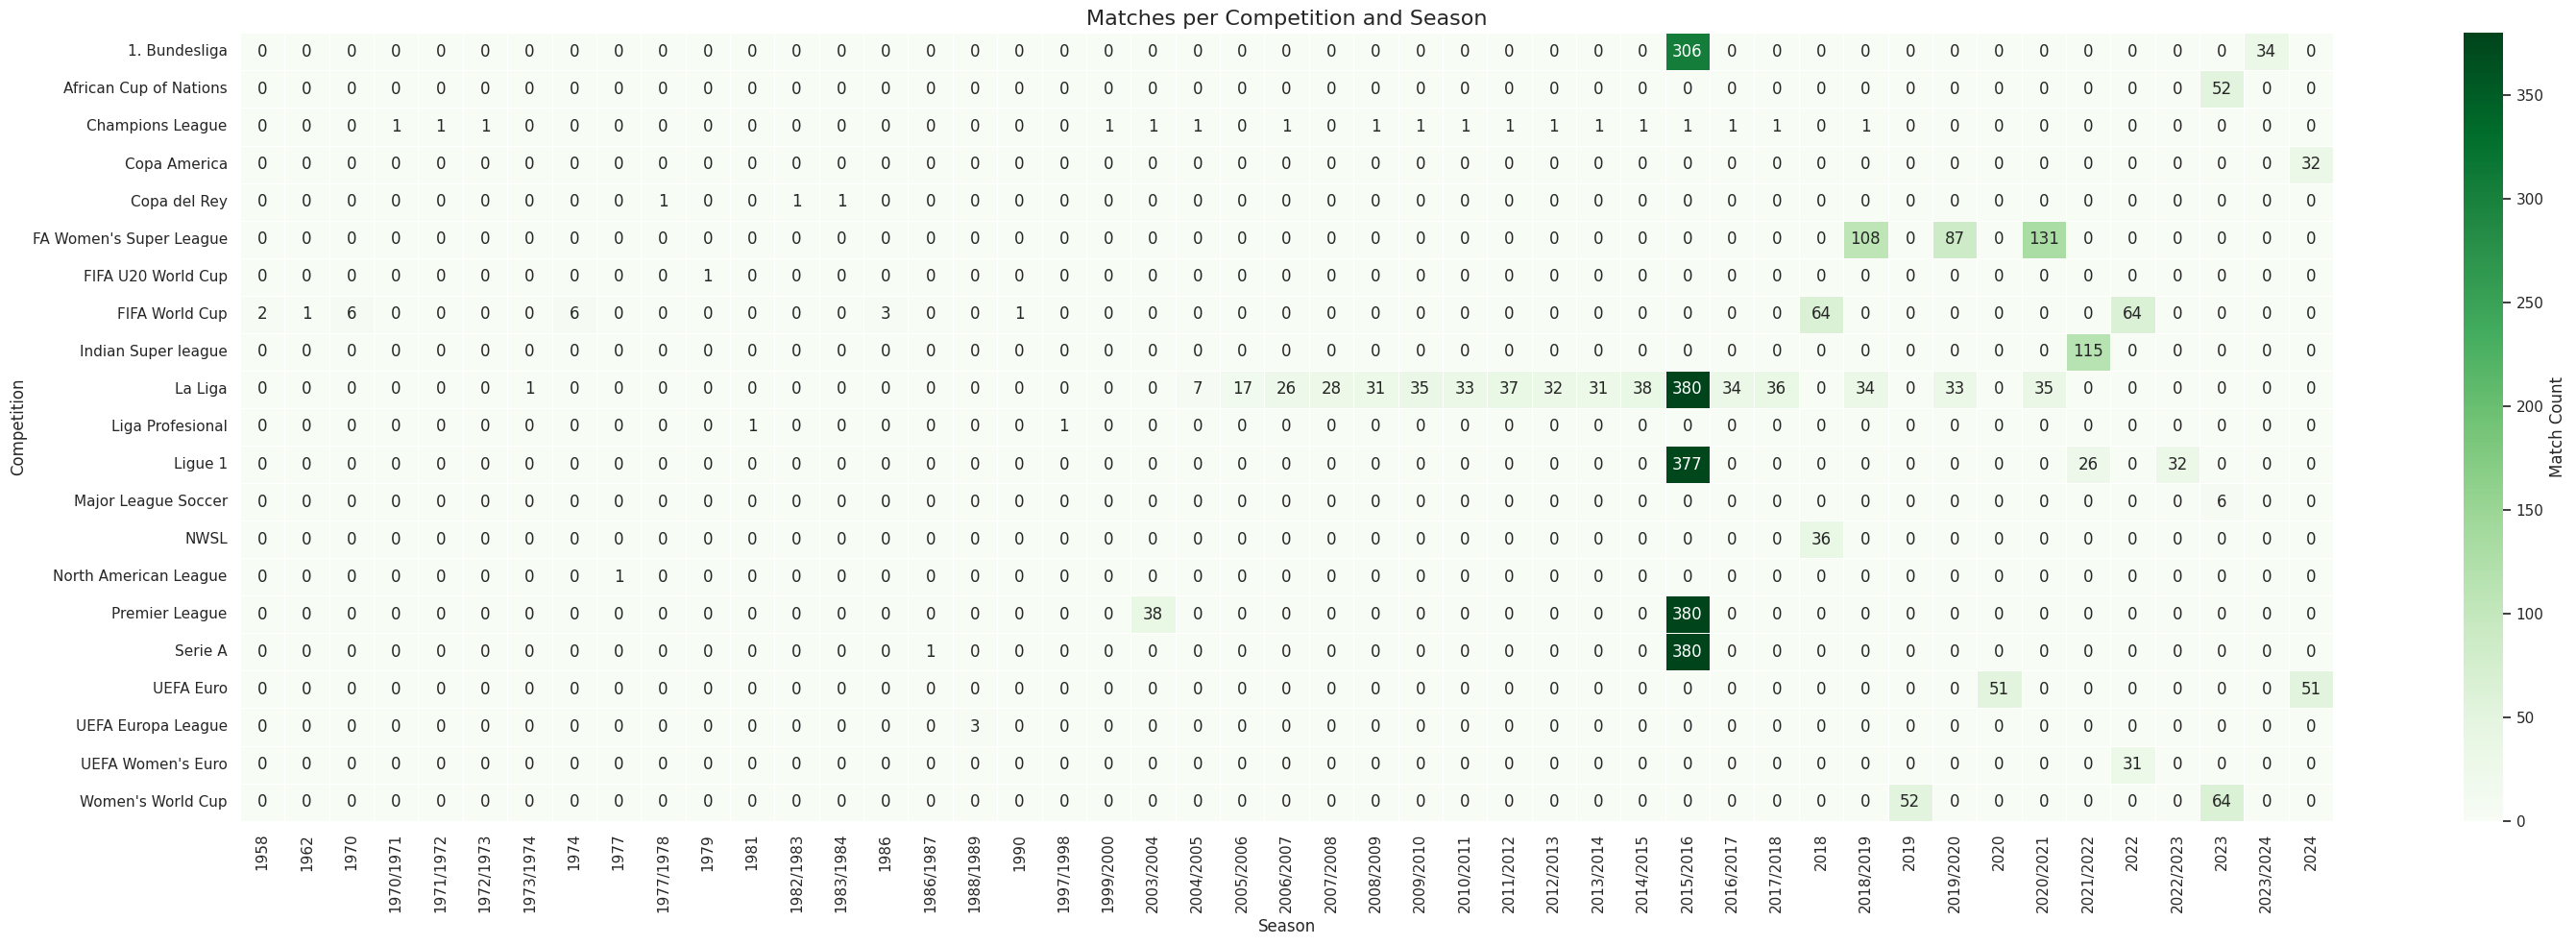

In [32]:
#Data per league can be from different seasons. Therefore a pivot with rows = competition, columns = season and values = match count is created to get a better overview of the available data

pivot = all_matches.pivot_table(
    index='competition_name',
    columns='season_name',
    values='match_id',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(30, 10))
sns.set(font_scale=1.0)

ax = sns.heatmap(pivot,
                 cmap = "Greens",
                 linewidths=0.5,
                 annot=True,
                 fmt='d',
                 cbar_kws={'label': 'Match Count'})

plt.title('Matches per Competition and Season', fontsize=16)
plt.xlabel('Season')
plt.ylabel('Competition')
plt.tight_layout()
plt.show()


In [33]:
#For building an xG model, I am only interested in shoots and their outcome. Therefore, I need to understand how to narrow my dataset down. For that I look into one example match.

#Opta provides data on all matches from Bayer Leverkusens unbeaten 2023/2024 season. Let's look at a match against RB Leipzig.
df_competition[(df_competition['competition_name'] == '1. Bundesliga') & (df_competition['season_name'] == '2023/2024')]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676


In [34]:
#Bundesliga competition_id = 9, 2023/2024 season_id = 281
df_match = parser.match(competition_id=9, season_id=281)
df_match.info()

lev_vs_rb_matches_df = df_match[(df_match['home_team_name'] == 'RB Leipzig') | (df_match['away_team_name'] == 'RB Leipzig')]
lev_vs_rb_matches_df.head()

#Both matches ended Leverkusen 3 - 2 Leipzig. Matches are uniquely identified using match_id. Now we look into the the match played in Leipzig.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   match_id                         34 non-null     int64         
 1   match_date                       34 non-null     datetime64[ns]
 2   kick_off                         34 non-null     datetime64[ns]
 3   home_score                       34 non-null     int64         
 4   away_score                       34 non-null     int64         
 5   match_status                     34 non-null     object        
 6   match_status_360                 34 non-null     object        
 7   last_updated                     34 non-null     datetime64[ns]
 8   last_updated_360                 34 non-null     datetime64[ns]
 9   match_week                       34 non-null     int64         
 10  competition_id                   34 non-null     int64         


,match_id,match_date,kick_off,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,...,competition_stage_id,competition_stage_name,stadium_id,stadium_name,stadium_country_id,stadium_country_name,referee_id,referee_name,referee_country_id,referee_country_name
23,3895202,2024-01-20,2024-01-20 19:30:00,2,3,available,available,2024-02-23 07:15:11.034109,2024-03-24 11:04:42.281656,18,...,1,Regular Season,376,Red Bull Arena,85,Germany,837,Matthias Jöllenbeck,85,Germany
33,3895052,2023-08-19,2023-08-19 16:30:00,3,2,available,available,2023-10-27 17:32:50.230518,2023-11-21 13:34:09.912520,1,...,1,Regular Season,377,BayArena,85,Germany,186,Felix Brych,85,Germany


In [35]:
df_event, df_related, df_freeze, df_tactics = parser.event(3895202)

#The events from the event interface are stored in three dataframes.
#df_event:
#df_related: A dataframe with the Ids of related events. For example, a shot might be related to the Goalkeeper event and a Block Event.The corresponding events will have the Id of the shot in their related_events column.
#df_freeze: Each shot includes an object called freeze_frame which is an array containing information about relevant players at the time of the shot.
#df_tactics: At the beginning of each match, an event is recorded for the tactics and lineups for each team.

df_event.info()
df_related.info()
df_freeze.info()
df_tactics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4008 entries, 0 to 4007
Data columns (total 70 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              4008 non-null   object 
 1   index                           4008 non-null   int64  
 2   period                          4008 non-null   int64  
 3   timestamp                       4008 non-null   object 
 4   minute                          4008 non-null   int64  
 5   second                          4008 non-null   int64  
 6   possession                      4008 non-null   int64  
 7   duration                        2936 non-null   float64
 8   match_id                        4008 non-null   int64  
 9   type_id                         4008 non-null   int64  
 10  type_name                       4008 non-null   object 
 11  possession_team_id              4008 non-null   int64  
 12  possession_team_name            40

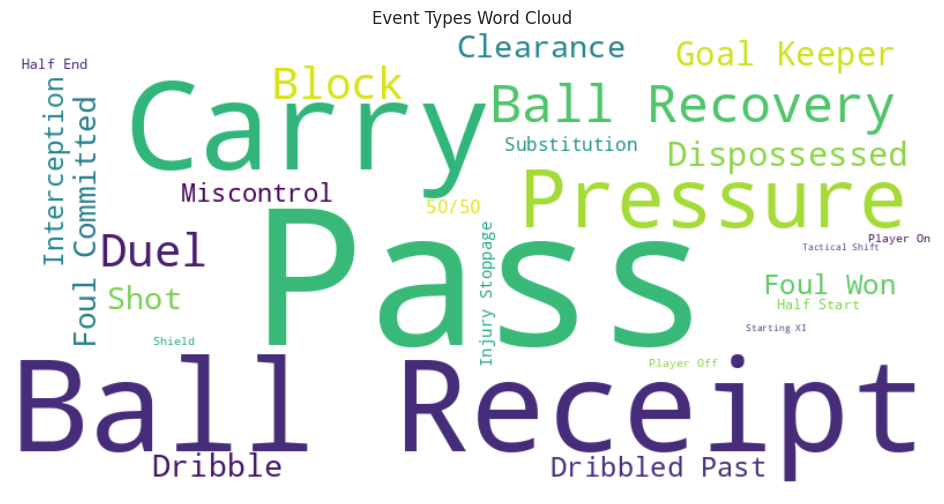

In [36]:
from wordcloud import WordCloud

event_counts = df_event['type_name'].value_counts().to_dict()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(event_counts)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Event Types Word Cloud')
plt.show()

In [37]:
#There are ~4000 events in this match and over 3000 matches available.
#To create a good foundation for the model training while keeping the dataframe size reasonable I will focus on events with type_name == Shot.

shots_df = df_event[df_event["type_name"] == 'Shot']
len(shots_df)

#Now the dataset was reduced to 28 rows. I want to look at them a bit closer.

28

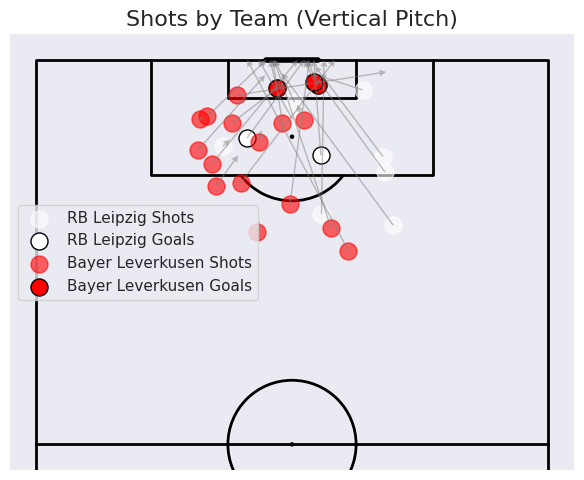

In [38]:
pitch = VerticalPitch(line_color='black', pitch_type='statsbomb', half=True)
fig, ax = pitch.draw(figsize=(6, 10))

team_info = shots_df[['team_id', 'team_name']].drop_duplicates()
team_info_dict = dict(zip(team_info['team_id'].astype(str), team_info['team_name']))

team_colors = {
    '182': 'white',
    '904': 'red'
}

for team_id_str, color in team_colors.items():
    team_name = team_info_dict.get(team_id_str, f'Team {team_id_str}')
    team_shots = shots_df[shots_df['team_id'].astype(str) == team_id_str]

    pitch.scatter(team_shots['x'], team_shots['y'], s=150, c=color, alpha=0.6, label=f'{team_name} Shots', ax=ax)

    team_goals = team_shots[team_shots['outcome_name'] == 'Goal']
    pitch.scatter(team_goals['x'], team_goals['y'], s=150, c=color, edgecolors='black', label=f'{team_name} Goals', ax=ax)

pitch.arrows(shots_df['x'], shots_df['y'], shots_df['end_x'], shots_df['end_y'], width=1, headwidth=5, headlength=5, color='gray', alpha=0.5, ax=ax)

ax.legend()
ax.set_title('Shots by Team (Vertical Pitch)', fontsize=16)
plt.show()

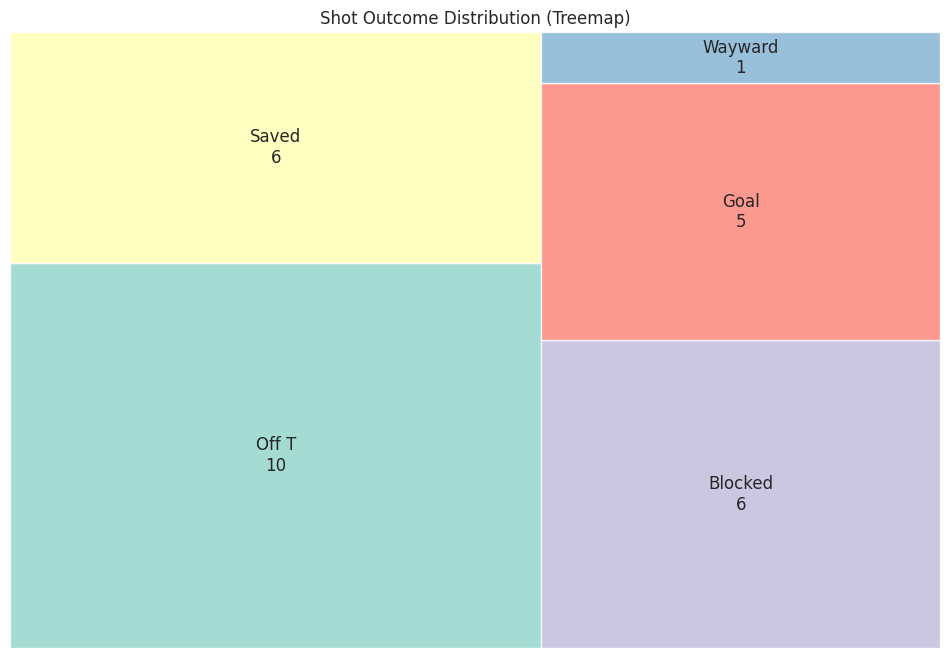

In [39]:
outcome_counts = shots_df['outcome_name'].value_counts()
labels = [f'{label}\n{count}' for label, count in zip(outcome_counts.index, outcome_counts.values)]


plt.figure(figsize=(12, 8))
squarify.plot(sizes=outcome_counts.values, label=labels, alpha=0.8, color=sns.color_palette("Set3", len(outcome_counts)))
plt.axis('off')
plt.title('Shot Outcome Distribution (Treemap)')
plt.show()


In [40]:
df_first_goal = shots_df[shots_df['outcome_name'] == 'Goal']
df_first_goal.head(5)

#The first goal has the ID 'd8ed50f7-263e-48bb-9ba4-60808125f244'. I want to use it to understand what df_freeze provides.

,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,...,pass_deflected,foul_committed_advantage,foul_won_advantage,ball_recovery_recovery_failure,substitution_replacement_id,substitution_replacement_name,dribble_nutmeg,foul_won_defensive,shot_open_goal,block_offensive
421,d8ed50f7-263e-48bb-9ba4-60808125f244,422,1,00:06:58.722000,6,58,13,0.974081,3895202,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2274,34b7332c-6c9a-418d-8b9d-8e7051e4eb1c,2275,2,00:01:16.021000,46,16,77,0.306203,3895202,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
2645,9f6e2212-3730-4628-83bd-bd3f9bcab98f,2646,2,00:10:08.671000,55,8,90,0.689404,3895202,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2906,cfc2c881-aa53-456f-b264-f07e54c71e50,2907,2,00:17:52.051000,62,52,101,0.243291,3895202,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3900,060082ee-d0e7-4741-b1d3-3ff14f6adb90,3901,2,00:45:40.453000,90,40,145,0.301214,3895202,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df_first_goal_freeze = df_freeze[df_freeze["id"] == 'd8ed50f7-263e-48bb-9ba4-60808125f244']
df_first_goal_freeze.info()
df_first_goal_freeze.head(13)

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, 28 to 45
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   teammate         18 non-null     bool   
 1   match_id         18 non-null     int64  
 2   id               18 non-null     object 
 3   x                18 non-null     float64
 4   y                18 non-null     float64
 5   player_id        18 non-null     int64  
 6   player_name      18 non-null     object 
 7   position_id      18 non-null     int64  
 8   position_name    18 non-null     object 
 9   event_freeze_id  18 non-null     int64  
dtypes: bool(1), float64(2), int64(4), object(3)
memory usage: 1.4+ KB


,teammate,match_id,id,x,y,player_id,player_name,position_id,position_name,event_freeze_id
28,False,3895202,d8ed50f7-263e-48bb-9ba4-60808125f244,105.2,29.7,3500,Granit Xhaka,9,Right Defensive Midfield,1
29,False,3895202,d8ed50f7-263e-48bb-9ba4-60808125f244,106.1,25.0,32712,Jeremie Frimpong,7,Right Wing Back,2
30,False,3895202,d8ed50f7-263e-48bb-9ba4-60808125f244,105.3,26.0,49337,Josip Stanišić,3,Right Center Back,3
31,False,3895202,d8ed50f7-263e-48bb-9ba4-60808125f244,102.0,30.0,8804,Jonas Hofmann,18,Right Attacking Midfield,4
32,False,3895202,d8ed50f7-263e-48bb-9ba4-60808125f244,95.6,33.9,7044,Patrik Schick,23,Center Forward,5
33,False,3895202,d8ed50f7-263e-48bb-9ba4-60808125f244,117.7,41.3,8667,Lukáš Hrádecký,1,Goalkeeper,6
34,False,3895202,d8ed50f7-263e-48bb-9ba4-60808125f244,110.1,43.3,38004,Piero Martín Hincapié Reyna,5,Left Center Back,7
35,False,3895202,d8ed50f7-263e-48bb-9ba4-60808125f244,106.5,47.4,10336,Alejandro Grimaldo García,8,Left Wing Back,8
36,False,3895202,d8ed50f7-263e-48bb-9ba4-60808125f244,106.2,44.8,40724,Florian Wirtz,20,Left Attacking Midfield,9
37,False,3895202,d8ed50f7-263e-48bb-9ba4-60808125f244,111.7,34.4,8221,Jonathan Tah,4,Center Back,10


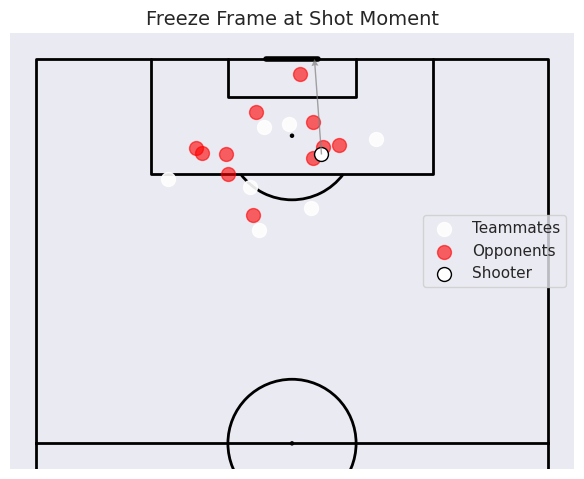

In [42]:
pitch = VerticalPitch(pitch_type='statsbomb', half=True, line_color='black')
fig, ax = pitch.draw(figsize=(6, 10))

event_id = 'd8ed50f7-263e-48bb-9ba4-60808125f244'

teammates = df_first_goal_freeze[df_first_goal_freeze['teammate'] == True]
opponents = df_first_goal_freeze[df_first_goal_freeze['teammate'] == False]


pitch.scatter(teammates['x'], teammates['y'], s=100, c='white', alpha=0.9, label='Teammates', ax=ax)

pitch.scatter(opponents['x'], opponents['y'], s=100, c='red', alpha=0.6, label='Opponents', ax=ax)

shooter = shots_df[shots_df['id'] == event_id].iloc[0]
pitch.scatter(shooter['x'], shooter['y'], s=100, c='white', edgecolors='black', label='Shooter', ax=ax)

pitch.arrows(shooter['x'], shooter['y'], shooter['end_x'], shooter['end_y'], width=1, headwidth=5, headlength=5, color='gray', alpha=0.7, ax=ax)

ax.set_title("Freeze Frame at Shot Moment", fontsize=14)
ax.legend(loc='right')
plt.show()


In [43]:
#After looking at df_related it is assumed to not be of value for the development of the xG model

df_related[df_related["id"] == 'd8ed50f7-263e-48bb-9ba4-60808125f244']

,match_id,id,index,type_name,id_related,index_related,type_name_related
602,3895202,d8ed50f7-263e-48bb-9ba4-60808125f244,422,Shot,47a221d5-65d5-4dbd-817d-aa9f041c59cc,423,Goal Keeper
600,3895202,d8ed50f7-263e-48bb-9ba4-60808125f244,422,Shot,919b2a50-9fdc-4fa2-a9b1-b643b4752966,419,Carry


In [44]:
#To understand shots and their representation in the df_event better the next step is to create a df for all shots in a specific tournament to see which columns are required for the project.
#For that I chose the 2023 Women's World Cup. It has competition_id = 72 and season_id = 107

df_competition[(df_competition['competition_name'] == "Women's World Cup") & (df_competition['season_name'] == '2023')]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
72,72,107,International,Women's World Cup,female,False,True,2023,2024-07-14T16:59:48.469596,2024-07-14T17:01:38.887279,2024-07-14T17:01:38.887279,2024-07-14T16:59:48.469596


In [45]:
matches_df = parser.match(competition_id=72, season_id=107)
match_ids = matches_df['match_id'].tolist()

all_shots = []

for match_id in match_ids:
    df_event, df_related, df_freeze, df_tactics = parser.event(match_id)

    df_shots = df_event[df_event['type_name'] == 'Shot'].copy()

    df_shots['match_id'] = match_id

    all_shots.append(df_shots)

shots_master_women_world_cup_df = pd.concat(all_shots, ignore_index=True)


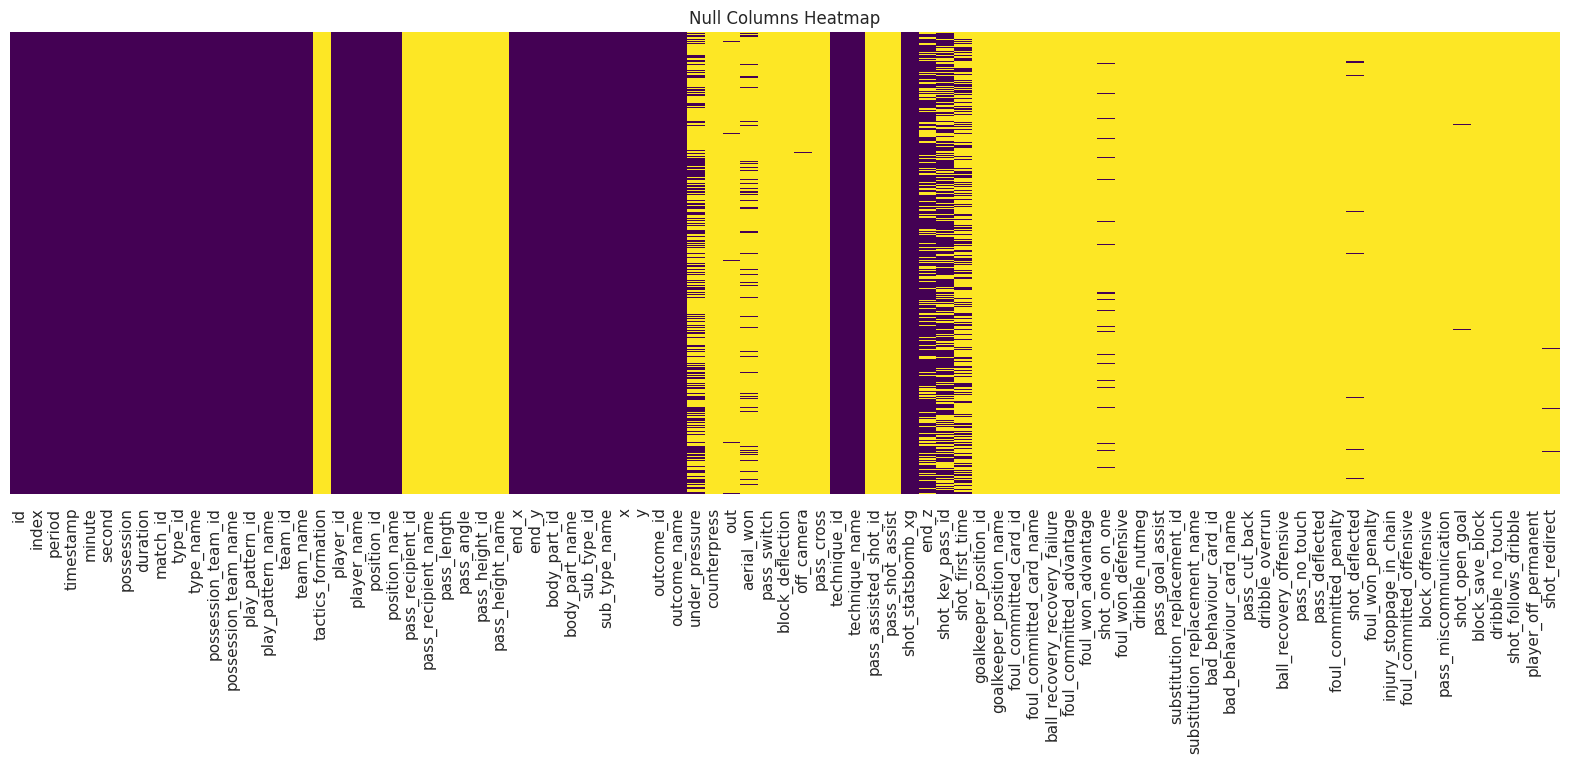

In [46]:
len(shots_master_women_world_cup_df)
#There are 1680 shots combined in all matches of the competition. Since we only look at shots, many columns in the df are unnecessary to keep. I want to identify those.

plt.figure(figsize=(20, 6))
sns.heatmap(shots_master_women_world_cup_df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Null Columns Heatmap")
plt.show()

In [47]:
before_shape = shots_master_women_world_cup_df.shape

null_columns = shots_master_women_world_cup_df.columns[shots_master_women_world_cup_df.isnull().all()]

print("Dropped columns (entirely null):")
print(list(null_columns))

shots_master_women_world_cup_df = shots_master_women_world_cup_df.drop(columns=null_columns)

after_shape = shots_master_women_world_cup_df.shape

print(f"\nDataFrame shape before: {before_shape}")
print(f"DataFrame shape after:  {after_shape}")
print(f"Total columns removed:  {before_shape[1] - after_shape[1]}")

Dropped columns (entirely null):
['tactics_formation', 'pass_recipient_id', 'pass_recipient_name', 'pass_length', 'pass_angle', 'pass_height_id', 'pass_height_name', 'counterpress', 'pass_switch', 'block_deflection', 'pass_cross', 'pass_assisted_shot_id', 'pass_shot_assist', 'goalkeeper_position_id', 'goalkeeper_position_name', 'foul_committed_card_id', 'foul_committed_card_name', 'ball_recovery_recovery_failure', 'foul_committed_advantage', 'foul_won_advantage', 'foul_won_defensive', 'dribble_nutmeg', 'pass_goal_assist', 'substitution_replacement_id', 'substitution_replacement_name', 'bad_behaviour_card_id', 'bad_behaviour_card_name', 'pass_cut_back', 'dribble_overrun', 'ball_recovery_offensive', 'pass_no_touch', 'pass_deflected', 'foul_committed_penalty', 'foul_won_penalty', 'injury_stoppage_in_chain', 'foul_committed_offensive', 'block_offensive', 'pass_miscommunication', 'block_save_block', 'dribble_no_touch', 'player_off_permanent']

DataFrame shape before: (1680, 87)
DataFrame sh

In [48]:
shots_master_women_world_cup_df.shape

# Summary stats for numeric columns
print(shots_master_women_world_cup_df.describe(include='number'))

# Summary stats for categorical columns
print(shots_master_women_world_cup_df.describe(include='object'))


             index       period       minute       second  possession  \
count  1680.000000  1680.000000  1680.000000  1680.000000  1680.00000   
mean   1996.845833     1.679167    54.217857    29.036310   109.33631   
std    1090.622546     0.789324    30.618892    16.921829    62.57748   
min      27.000000     1.000000     0.000000     0.000000     2.00000   
25%    1076.000000     1.000000    29.000000    14.750000    57.75000   
50%    2030.000000     2.000000    52.000000    29.000000   107.00000   
75%    2897.500000     2.000000    80.000000    44.000000   156.25000   
max    4535.000000     5.000000   139.000000    59.000000   283.00000   

          duration      match_id  type_id  possession_team_id  \
count  1680.000000  1.680000e+03   1680.0         1680.000000   
mean      0.773370  3.896242e+06     16.0         2330.042857   
std       0.587594  4.063023e+03      0.0         4175.049519   
min       0.007054  3.893787e+06     16.0          851.000000   
25%       0.33291

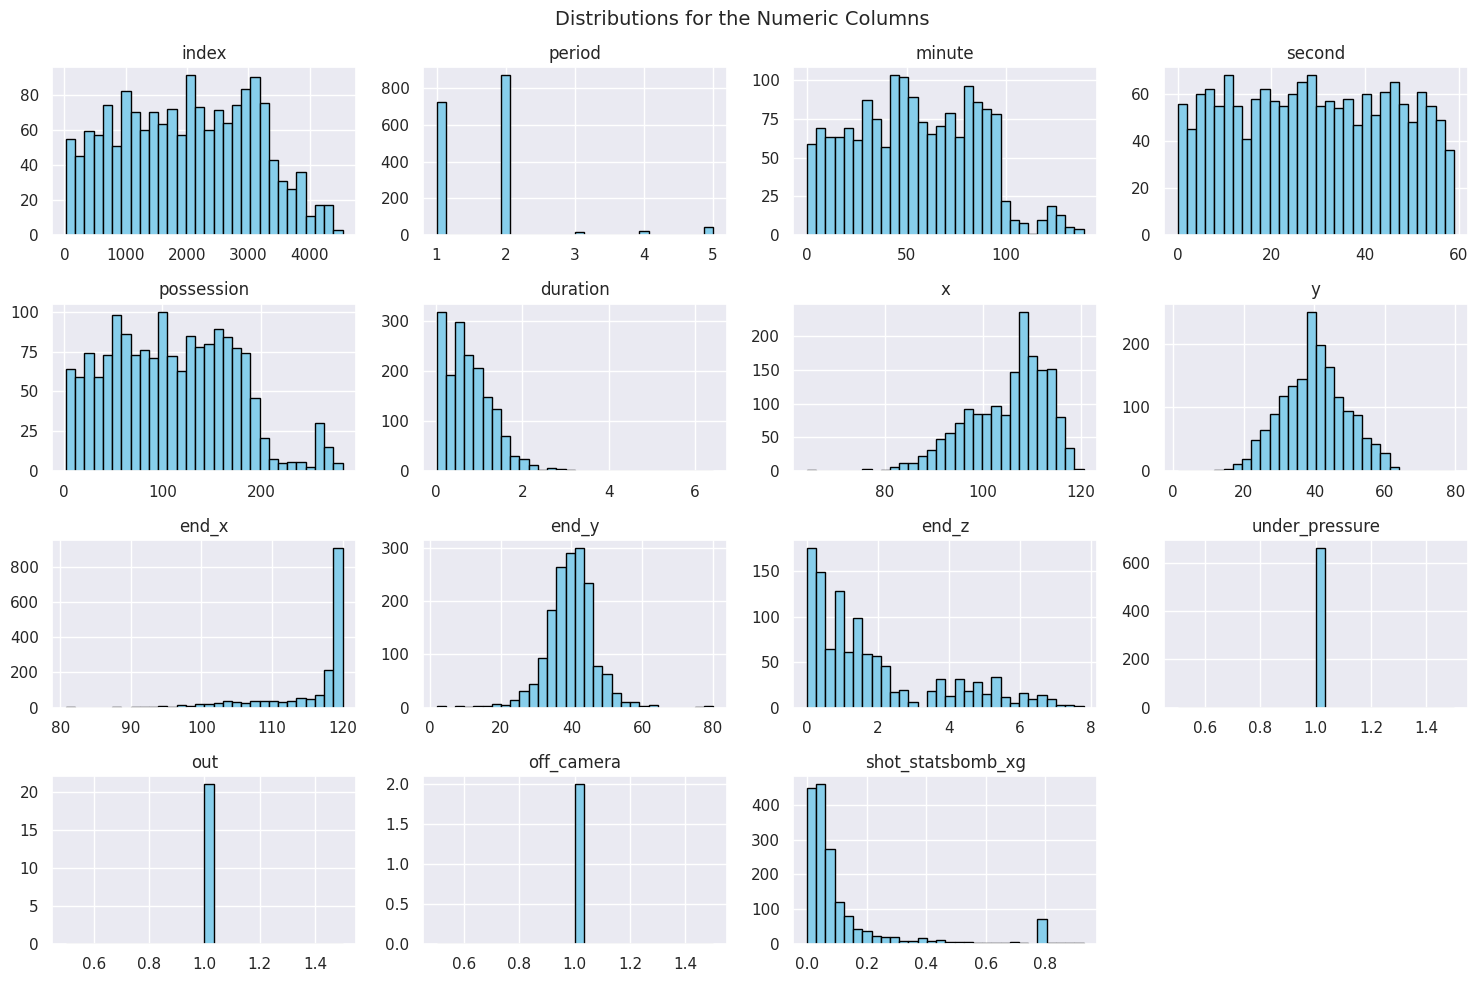

In [49]:
bar_color = 'skyblue'
edge_color = 'black'
title_fontsize = 14

numeric_cols = shots_master_women_world_cup_df.select_dtypes(include='number').columns

#Although numeric, some columns dont make sense to analyse in a numeric way. E.g. the _id columns are just a representation of categorical values via an id. These can be excluded

numerical_columns_to_visualize = [
    'index',
    'period',
    'minute',
    'second',
    'possession',
    'duration',
    #'match_id',
    #'type_id',
    #'possession_team_id',
    #'play_pattern_id',
    #'team_id',
    #'player_id',
    #'position_id',
    'x',
    'y',
    'end_x',
    'end_y',
    'end_z',
    #'body_part_id',
    #'sub_type_id',
    #'outcome_id',
    'under_pressure',
    'out',
    'off_camera',
    #'technique_id',
    'shot_statsbomb_xg'
]

shots_master_women_world_cup_df[numerical_columns_to_visualize].hist(
    bins=30,
    figsize=(15, 10),
    edgecolor=edge_color,
    color=bar_color
)
plt.suptitle('Distributions for the Numeric Columns', fontsize=title_fontsize)
plt.tight_layout()
plt.show()

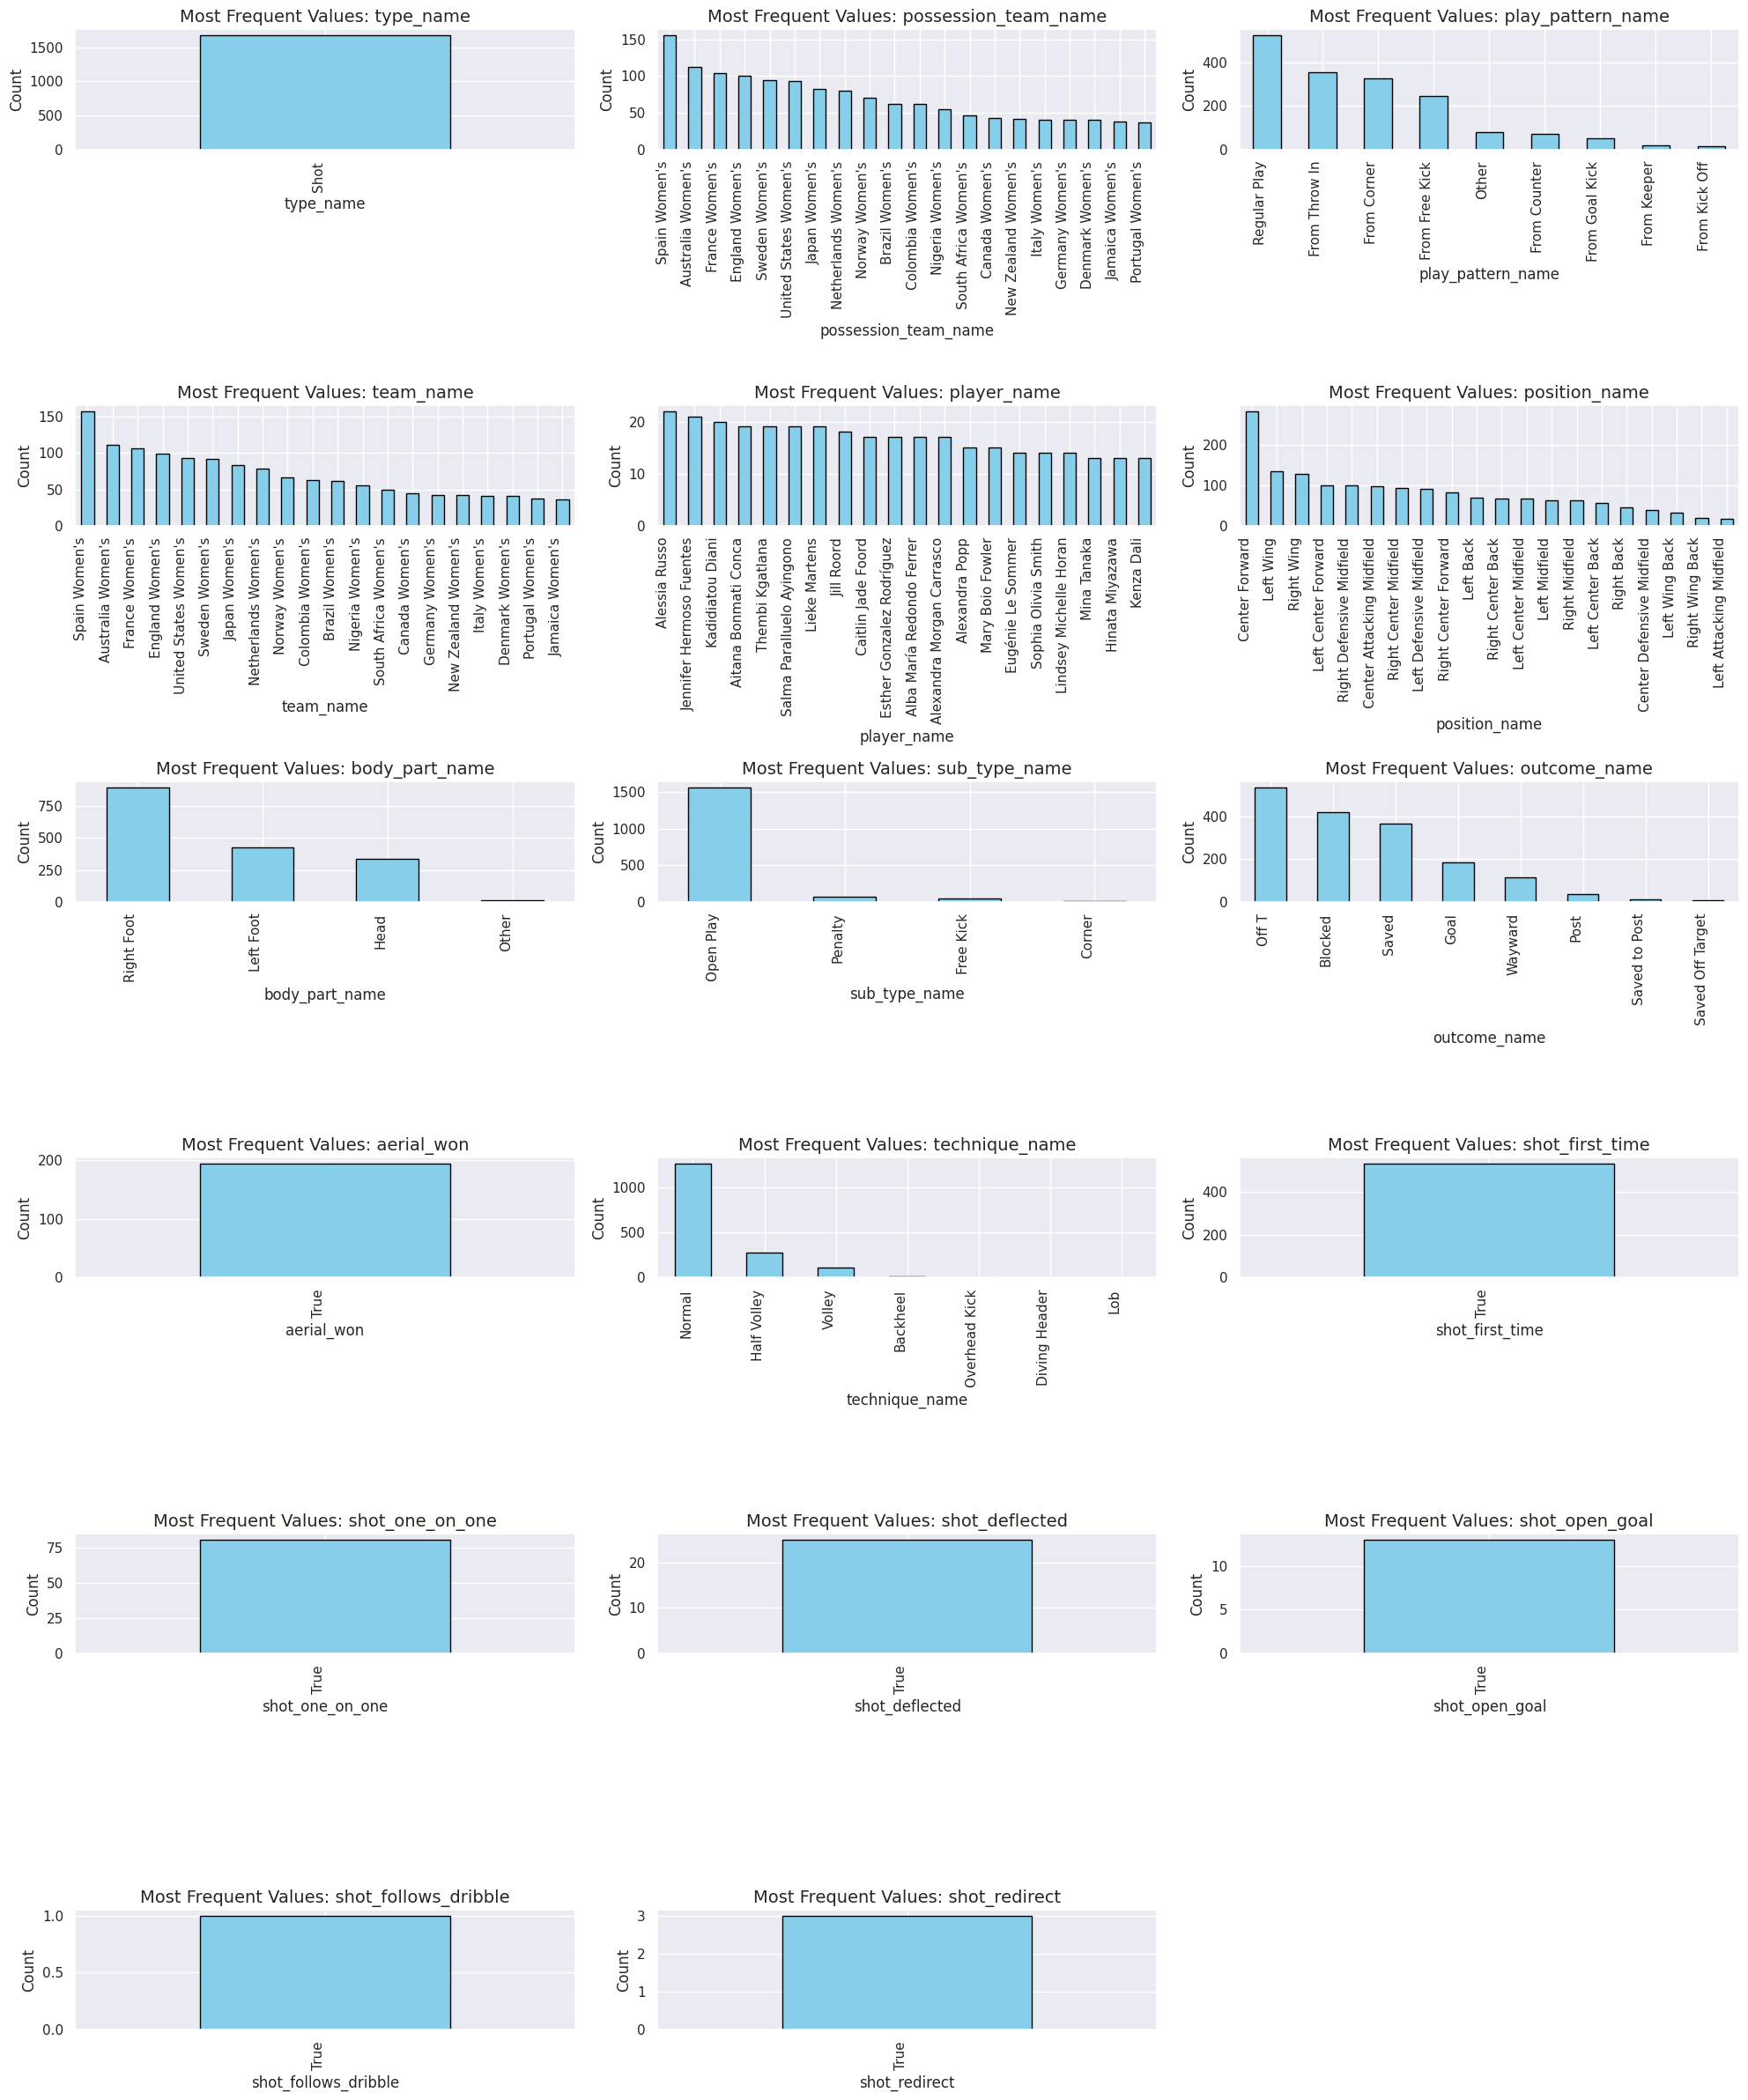

In [50]:
bar_color = 'skyblue'
edge_color = 'black'
title_fontsize = 14

categorical_cols = shots_master_women_world_cup_df.select_dtypes(include='object').columns

categorical_columns_to_visualize = [
    #'id',
    #'timestamp',
    'type_name',
    'possession_team_name',
    'play_pattern_name',
    'team_name',
    'player_name',
    'position_name',
    'body_part_name',
    'sub_type_name',
    'outcome_name',
    'aerial_won',
    'technique_name',
    #'shot_key_pass_id',
    'shot_first_time',
    'shot_one_on_one',
    'shot_deflected',
    'shot_open_goal',
    'shot_follows_dribble',
    'shot_redirect'
]

n_cols = 3
n_rows = int(np.ceil(len(categorical_columns_to_visualize) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(categorical_columns_to_visualize):
    ax = axes[i]
    shots_master_women_world_cup_df[col].value_counts().head(20).plot(kind='bar', color=bar_color, edgecolor=edge_color, ax=ax)
    ax.set_title(f"Most Frequent Values: {col}", fontsize=title_fontsize)
    ax.set_ylabel("Count")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

#Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

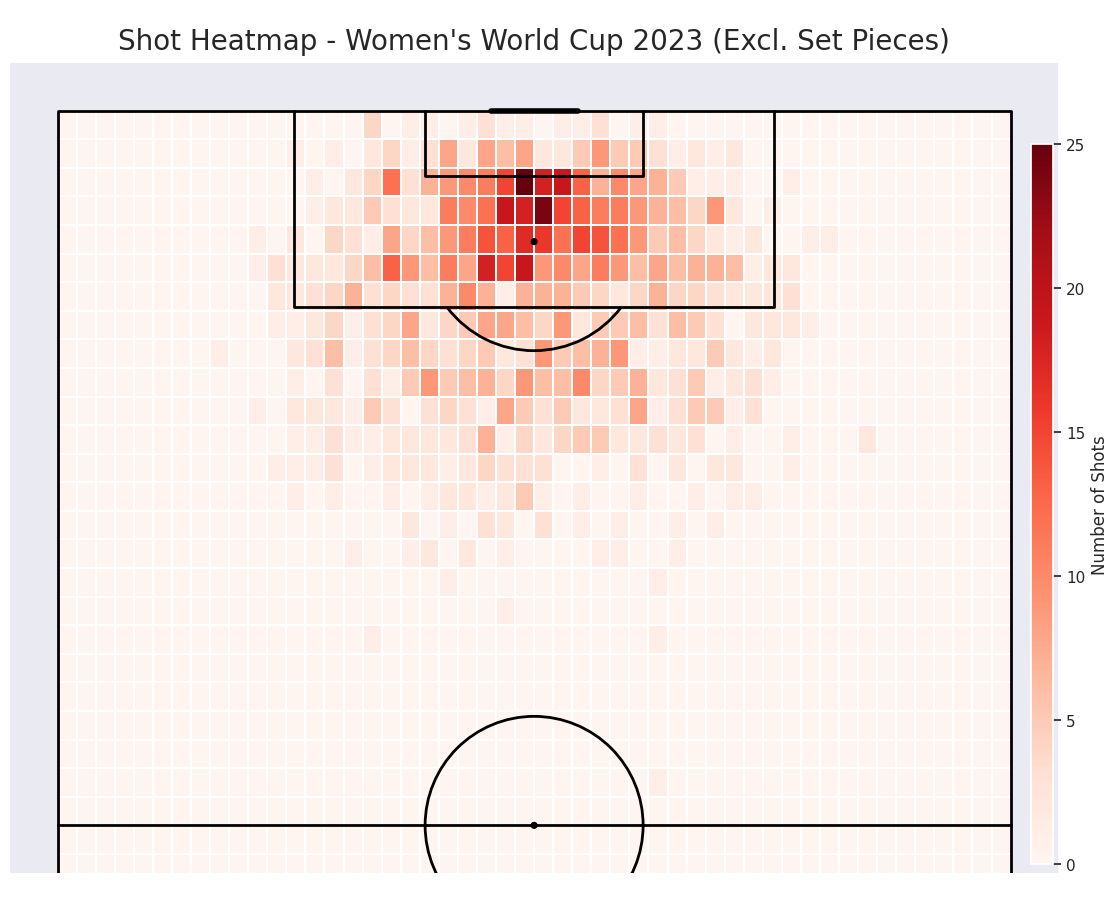

In [51]:
#Now I want to look closer at the shots to get a better feeling on the data. First I check where the 1680 shots came from in the Women's World Cup 2023

#We filter for all shots with sub_type_name = Open Play, because set pieces like penalties follow a different logic
shots_open_play = shots_master_women_world_cup_df[shots_master_women_world_cup_df['sub_type_name'] == 'Open Play']

pitch = VerticalPitch(
    line_color='black',
    half=True,
    pitch_type='custom',
    pitch_length=120,
    pitch_width=80,
    line_zorder=2
)

fig, ax = pitch.grid(
    grid_height=0.9,
    title_height=0.06,
    axis=False,
    endnote_height=0.04,
    title_space=0,
    endnote_space=0
)

bin_statistic_shots = pitch.bin_statistic(
    shots_open_play['x'],
    shots_open_play['y'],
    bins=(50, 50)
)

pcm = pitch.heatmap(
    bin_statistic_shots,
    ax=ax['pitch'],
    cmap='Reds',
    edgecolor='white',
    linewidth=0.01
)

ax_cbar = fig.add_axes((0.95, 0.05, 0.02, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
cbar.set_label('Number of Shots')

fig.suptitle('Shot Heatmap - Women\'s World Cup 2023 (Excl. Set Pieces)', fontsize=20)
plt.show()


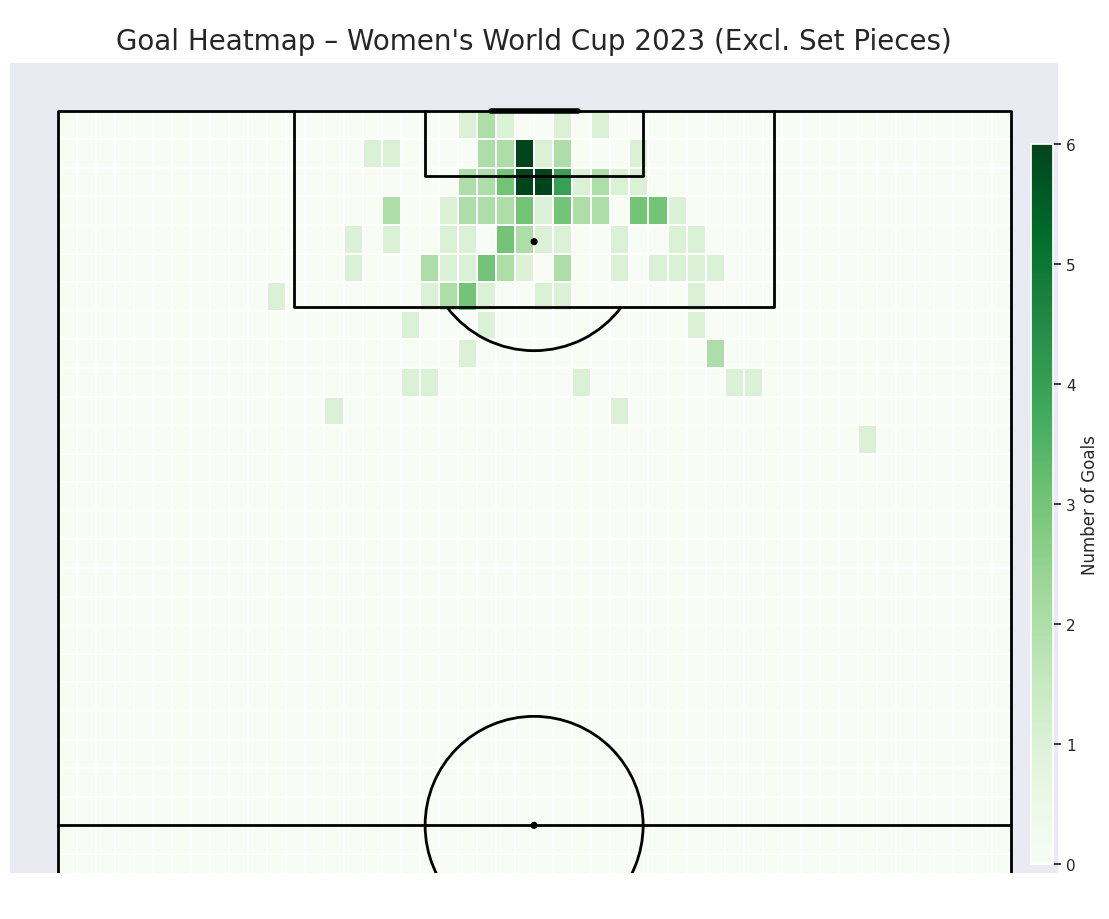

In [52]:
#Next I want to see from which locations the goals were scored. Therefore we filter for outcome_name = Goal

goals = shots_open_play[shots_open_play['outcome_name'] == 'Goal']

pitch = VerticalPitch(
    line_color='black',
    half=True,
    pitch_type='custom',
    pitch_length=120,
    pitch_width=80,
    line_zorder=2
)

fig, ax = pitch.grid(
    grid_height=0.9,
    title_height=0.06,
    axis=False,
    endnote_height=0.04,
    title_space=0,
    endnote_space=0
)

bin_statistic_goals = pitch.bin_statistic(
    goals['x'],
    goals['y'],
    bins=(50, 50)
)

pcm = pitch.heatmap(
    bin_statistic_goals,
    ax=ax['pitch'],
    cmap='Greens',
    edgecolor='white',
    linewidth=0.01
)

ax_cbar = fig.add_axes((0.95, 0.05, 0.02, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
cbar.set_label('Number of Goals')

fig.suptitle('Goal Heatmap – Women\'s World Cup 2023 (Excl. Set Pieces)', fontsize=20)
plt.show()

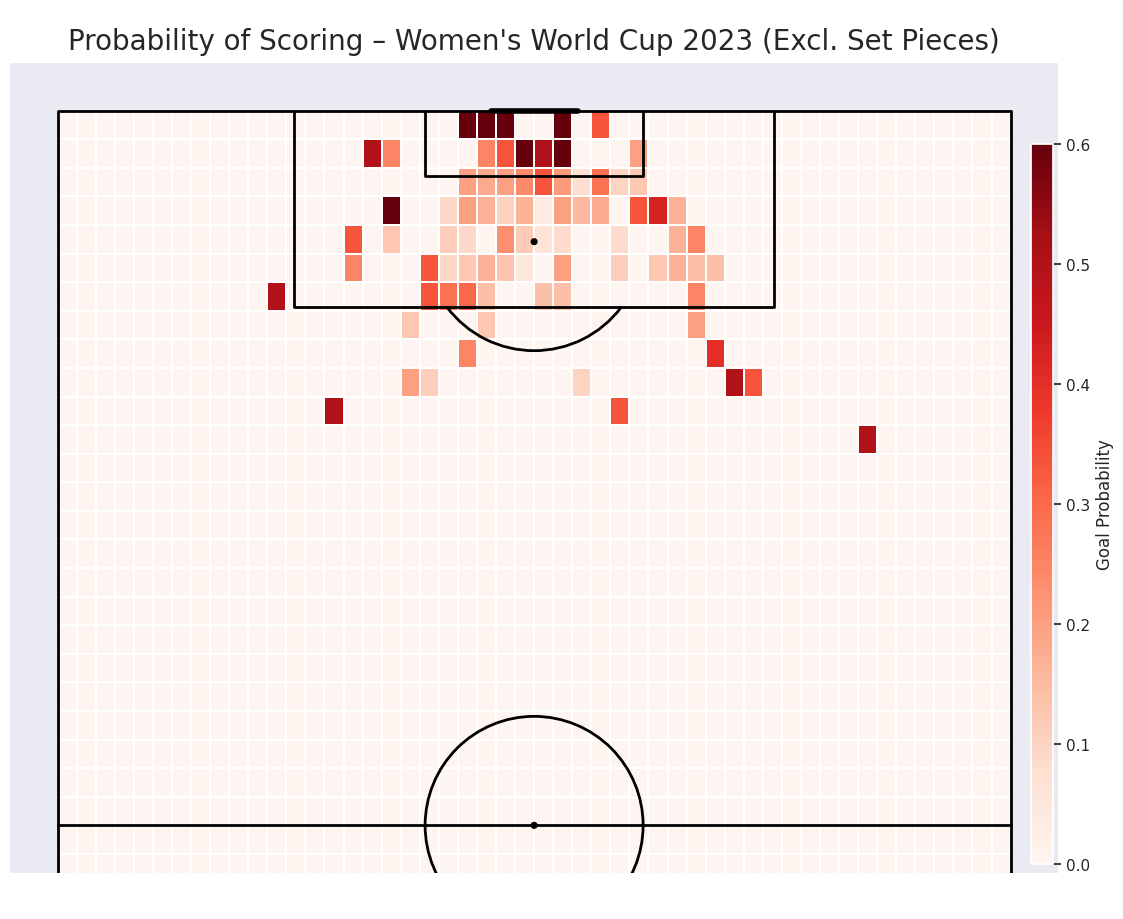

In [53]:
#Lastly I want to calculate the proportion of goals scored from each bin to number of shots from that location

shots_open_play


shots = shots_open_play
goals = shots_open_play[shots_open_play['outcome_name'] == 'Goal']

pitch = VerticalPitch(
    line_color='black',
    half=True,
    pitch_type='custom',
    pitch_length=120,
    pitch_width=80,
    line_zorder=2
)

fig, ax = pitch.grid(
    grid_height=0.9,
    title_height=0.06,
    axis=False,
    endnote_height=0.04,
    title_space=0,
    endnote_space=0
)


bin_shots = pitch.bin_statistic(shots['x'], shots['y'], bins=(50, 50))
bin_goals = pitch.bin_statistic(goals['x'], goals['y'], bins=(50, 50))

goal_probability = bin_goals['statistic'] / bin_shots['statistic']
goal_probability = np.nan_to_num(goal_probability, nan=0.0, posinf=0.0, neginf=0.0)
bin_shots['statistic'] = goal_probability

pcm = pitch.heatmap(
    bin_shots,
    ax=ax['pitch'],
    cmap='Reds',
    edgecolor='white',
    vmin=0,
    vmax=0.6,
    linewidth=0.01
)

ax_cbar = fig.add_axes((0.95, 0.05, 0.02, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
cbar.set_label('Goal Probability')

fig.suptitle('Probability of Scoring – Women\'s World Cup 2023 (Excl. Set Pieces)', fontsize=20)
plt.show()